In [3]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


In [4]:
# Load dataset
data_dir = '/Users/melisha/Desktop/5th sem project/dataset'
categories = os.listdir(data_dir)

In [9]:
# Preprocess images
def load_data(data_dir, categories, img_size=128):
    data = []
    labels = []
    for category in categories:
        category_path = os.path.join(data_dir, category)
        if not os.path.isdir(category_path):
            continue  # Skip if it's not a directory
        class_num = categories.index(category)
        for img in os.listdir(category_path):
            try:
                img_array = cv2.imread(os.path.join(category_path, img))
                resized_array = cv2.resize(img_array, (img_size, img_size))
                data.append(resized_array)
                labels.append(class_num)
            except Exception as e:
                print(f"Error reading image {os.path.join(category_path, img)}: {e}")
    return np.array(data), np.array(labels)
img_size = 128
X, y = load_data(data_dir, categories, img_size)

In [10]:
# Normalize data
X = X / 255.0
y = to_categorical(y, num_classes=len(categories))

In [11]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)
datagen.fit(X_train)


In [13]:
# Build CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(categories), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=25, validation_data=(X_test, y_test))


/Users/melisha/Desktop/5th sem project/plant-disease-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25


/Users/melisha/Desktop/5th sem project/plant-disease-env/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


516/516 ━━━━━━━━━━━━━━━━━━━━ 208s 398ms/step - accuracy: 0.2731 - loss: 2.2681 - val_accuracy: 0.6180 - val_loss: 1.1649
Epoch 2/25
516/516 ━━━━━━━━━━━━━━━━━━━━ 200s 386ms/step - accuracy: 0.5827 - loss: 1.2781 - val_accuracy: 0.7590 - val_loss: 0.7296
Epoch 3/25
516/516 ━━━━━━━━━━━━━━━━━━━━ 193s 373ms/step - accuracy: 0.6614 - loss: 1.0070 - val_accuracy: 0.7636 - val_loss: 0.7001
Epoch 4/25
516/516 ━━━━━━━━━━━━━━━━━━━━ 190s 367ms/step - accuracy: 0.7200 - loss: 0.8306 - val_accuracy: 0.8256 - val_loss: 0.5466
Epoch 5/25
516/516 ━━━━━━━━━━━━━━━━━━━━ 188s 363ms/step - accuracy: 0.7500 - loss: 0.7361 - val_accuracy: 0.8292 - val_loss: 0.5000
Epoch 6/25
516/516 ━━━━━━━━━━━━━━━━━━━━ 188s 363ms/step - accuracy: 0.7606 - loss: 0.7069 - val_accuracy: 0.8576 - val_loss: 0.3917
Epoch 7/25
516/516 ━━━━━━━━━━━━━━━━━━━━ 189s 365ms/step - accuracy: 0.7927 - loss: 0.6277 - val_accuracy: 0.8748 - val_loss: 0.3635
Epoch 8/25
516/516 ━━━━━━━━━━━━━━━━━━━━ 189s 365ms/step - accuracy: 0.8008 - loss: 0.59

In [15]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

# Save the model
model.save('plant_disease_model.h5')


129/129 ━━━━━━━━━━━━━━━━━━━━ 13s 98ms/step - accuracy: 0.9041 - loss: 0.2935


Loss: 0.29679062962532043, Accuracy: 0.9052810072898865


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


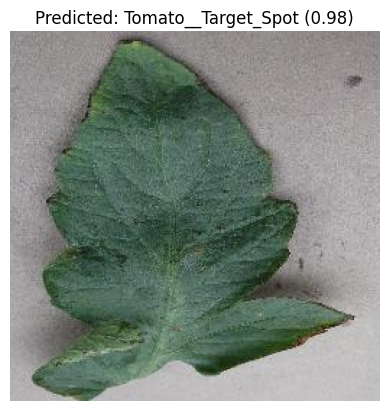

Predicted Disease: Tomato__Target_Spot, Confidence: 0.98


In [20]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('plant_disease_model.h5')

# Define a function to preprocess the input image
def preprocess_image(image_path, img_size=128):
    img_array = cv2.imread(image_path)
    if img_array is None:
        raise ValueError(f"Image at path {image_path} could not be loaded.")
    resized_array = cv2.resize(img_array, (img_size, img_size))
    normalized_array = resized_array / 255.0
    return np.expand_dims(normalized_array, axis=0)

# Define a function to make predictions
def predict_disease(image_path, model, categories):
    preprocessed_image = preprocess_image(image_path)
    prediction = model.predict(preprocessed_image)
    predicted_class = np.argmax(prediction, axis=1)[0]
    disease_name = categories[predicted_class]
    confidence = np.max(prediction)
    
    # Plot the image and prediction
    img_array = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
    
    plt.imshow(img_rgb)
    plt.title(f'Predicted: {disease_name} ({confidence:.2f})')
    plt.axis('off')
    plt.show()
    
    return disease_name, confidence

# Example usage
image_path = '/Users/melisha/Desktop/5th sem project/1.JPG'
data_dir = '/Users/melisha/Desktop/5th sem project/dataset'
categories = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

try:
    disease_name, confidence = predict_disease(image_path, model, categories)
    print(f'Predicted Disease: {disease_name}, Confidence: {confidence:.2f}')
except ValueError as e:
    print(e)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


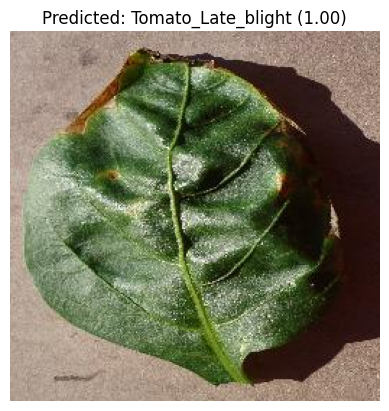

Predicted Disease: Tomato_Late_blight, Confidence: 1.00


In [21]:
image_path = '/Users/melisha/Desktop/5th sem project/3.JPG'
data_dir = '/Users/melisha/Desktop/5th sem project/dataset'
categories = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

try:
    disease_name, confidence = predict_disease(image_path, model, categories)
    print(f'Predicted Disease: {disease_name}, Confidence: {confidence:.2f}')
except ValueError as e:
    print(e)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


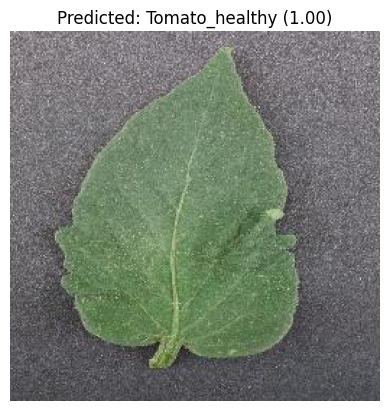

Predicted Disease: Tomato_healthy, Confidence: 1.00


In [24]:
image_path = '/Users/melisha/Desktop/5th sem project/4.JPG'
data_dir = '/Users/melisha/Desktop/5th sem project/dataset'
categories = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

try:
    disease_name, confidence = predict_disease(image_path, model, categories)
    print(f'Predicted Disease: {disease_name}, Confidence: {confidence:.2f}')
except ValueError as e:
    print(e)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


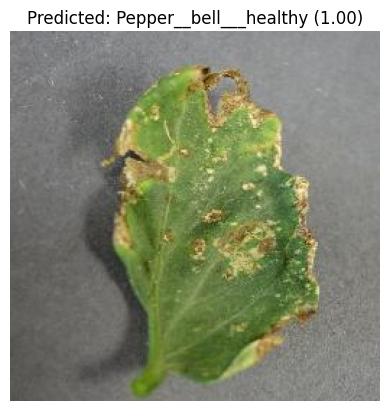

Predicted Disease: Pepper__bell___healthy, Confidence: 1.00


In [25]:
image_path = '/Users/melisha/Desktop/5th sem project/2.JPG'
data_dir = '/Users/melisha/Desktop/5th sem project/dataset'
categories = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

try:
    disease_name, confidence = predict_disease(image_path, model, categories)
    print(f'Predicted Disease: {disease_name}, Confidence: {confidence:.2f}')
except ValueError as e:
    print(e)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


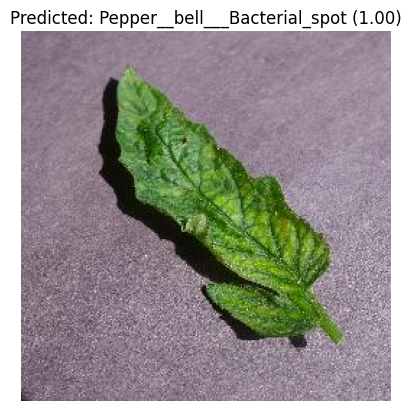

Predicted Disease: Pepper__bell___Bacterial_spot, Confidence: 1.00


In [12]:
image_path = '/Users/melisha/Desktop/6th sem project/6.JPG'
data_dir = '/Users/melisha/Desktop/6th sem project/dataset'
categories = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

try:
    disease_name, confidence = predict_disease(image_path, model, categories)
    print(f'Predicted Disease: {disease_name}, Confidence: {confidence:.2f}')
except ValueError as e:
    print(e)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


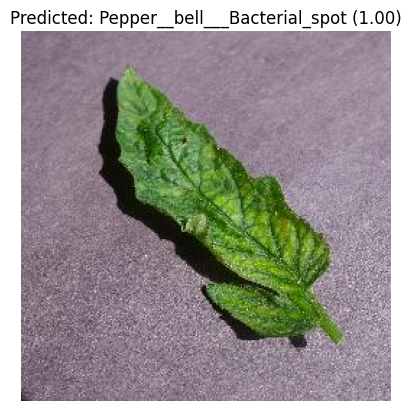

Predicted Disease: Pepper__bell___Bacterial_spot, Confidence: 1.00


In [4]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('plant_disease_model.h5')

# Define a function to preprocess the input image
def preprocess_image(image_path, img_size=128):
    img_array = cv2.imread(image_path)
    if img_array is None:
        raise ValueError(f"Image at path {image_path} could not be loaded.")
    resized_array = cv2.resize(img_array, (img_size, img_size))
    normalized_array = resized_array / 255.0
    return np.expand_dims(normalized_array, axis=0)

# Define a function to make predictions
def predict_disease(image_path, model, categories):
    preprocessed_image = preprocess_image(image_path)
    prediction = model.predict(preprocessed_image)
    predicted_class = np.argmax(prediction, axis=1)[0]
    disease_name = categories[predicted_class]
    confidence = np.max(prediction)
    
    # Plot the image and prediction
    img_array = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
    
    plt.imshow(img_rgb)
    plt.title(f'Predicted: {disease_name} ({confidence:.2f})')
    plt.axis('off')
    plt.show()
    
    return disease_name, confidence

# Example usage
image_path = '/Users/melisha/Desktop/6th sem project/6.jpg'
data_dir = '/Users/melisha/Desktop/6th sem project/dataset'
categories = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

try:
    disease_name, confidence = predict_disease(image_path, model, categories)
    print(f'Predicted Disease: {disease_name}, Confidence: {confidence:.2f}')
except ValueError as e:
    print(e)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


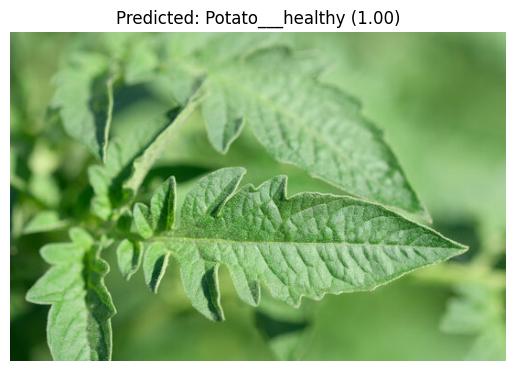

Predicted Disease: Potato___healthy, Confidence: 1.00


In [5]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('plant_disease_model.h5')

# Define a function to preprocess the input image
def preprocess_image(image_path, img_size=128):
    img_array = cv2.imread(image_path)
    if img_array is None:
        raise ValueError(f"Image at path {image_path} could not be loaded.")
    resized_array = cv2.resize(img_array, (img_size, img_size))
    normalized_array = resized_array / 255.0
    return np.expand_dims(normalized_array, axis=0)

# Define a function to make predictions
def predict_disease(image_path, model, categories):
    preprocessed_image = preprocess_image(image_path)
    prediction = model.predict(preprocessed_image)
    predicted_class = np.argmax(prediction, axis=1)[0]
    disease_name = categories[predicted_class]
    confidence = np.max(prediction)
    
    # Plot the image and prediction
    img_array = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
    
    plt.imshow(img_rgb)
    plt.title(f'Predicted: {disease_name} ({confidence:.2f})')
    plt.axis('off')
    plt.show()
    
    return disease_name, confidence

# Example usage
image_path = '/Users/melisha/Desktop/6th sem project/77.jpg'
data_dir = '/Users/melisha/Desktop/6th sem project/dataset'
categories = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

try:
    disease_name, confidence = predict_disease(image_path, model, categories)
    print(f'Predicted Disease: {disease_name}, Confidence: {confidence:.2f}')
except ValueError as e:
    print(e)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


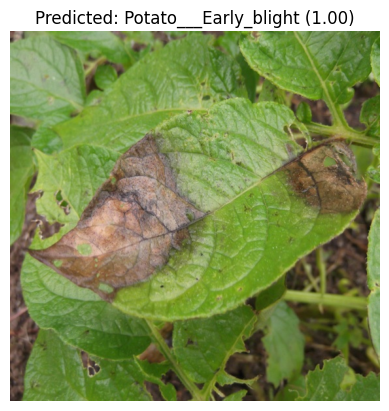

Predicted Disease: Potato___Early_blight, Confidence: 1.00


In [8]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('plant_disease_model.h5')

# Define a function to preprocess the input image
def preprocess_image(image_path, img_size=128):
    img_array = cv2.imread(image_path)
    if img_array is None:
        raise ValueError(f"Image at path {image_path} could not be loaded.")
    resized_array = cv2.resize(img_array, (img_size, img_size))
    normalized_array = resized_array / 255.0
    return np.expand_dims(normalized_array, axis=0)

# Define a function to make predictions
def predict_disease(image_path, model, categories):
    preprocessed_image = preprocess_image(image_path)
    prediction = model.predict(preprocessed_image)
    predicted_class = np.argmax(prediction, axis=1)[0]
    disease_name = categories[predicted_class]
    confidence = np.max(prediction)
    
    # Plot the image and prediction
    img_array = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
    
    plt.imshow(img_rgb)
    plt.title(f'Predicted: {disease_name} ({confidence:.2f})')
    plt.axis('off')
    plt.show()
    
    return disease_name, confidence

# Example usage
image_path = '/Users/melisha/Desktop/6th sem project/9.jpg'
data_dir = '/Users/melisha/Desktop/6th sem project/dataset'
categories = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

try:
    disease_name, confidence = predict_disease(image_path, model, categories)
    print(f'Predicted Disease: {disease_name}, Confidence: {confidence:.2f}')
except ValueError as e:
    print(e)
